In [3]:
import cv2
import numpy as np
from tensorflow.keras import models

In [4]:
class StageStatus(object):
    """
    Keeps status between MTCNN stages
    """

    def __init__(self, pad_result: tuple = None, width=0, height=0):
        self.width = width
        self.height = height
        self.dy = self.edy = self.dx = self.edx = self.y = self.ey = self.x = self.ex = self.tmpw = self.tmph = []

        if pad_result is not None:
            self.update(pad_result)

    def update(self, pad_result: tuple):
        s = self
        s.dy, s.edy, s.dx, s.edx, s.y, s.ey, s.x, s.ex, s.tmpw, s.tmph = pad_result

In [5]:
class MTCNN(object):


    def __init__(self, weights_file: str = None, min_face_size: int = 20, steps_threshold: list = None,
                 scale_factor: float = 0.709):

        if steps_threshold is None:
            steps_threshold = [0.6, 0.7, 0.7]

        self._min_face_size = min_face_size
        self._steps_threshold = steps_threshold
        self._scale_factor = scale_factor
         
        #################
        self._pnet_base = models.load_model("model/p_net_base.h5",compile=False)
        self._pnet_out_1 = models.load_model("model/p_net_out_1.h5",compile=False) # (N,N,2)
        self._pnet_out_2 = models.load_model("model/p_net_out_2.h5",compile=False) # (N,N,4)
        #################
            
        #################
        self._rnet_base = models.load_model("model/r_net_base.h5",compile=False)
        self._rnet_out_1 = models.load_model("model/r_net_out_1.h5",compile=False)
        self._rnet_out_2 = models.load_model("model/r_net_out_2.h5",compile=False)
        #################
             
        #################
        self._onet_base = models.load_model("model/o_net_base.h5",compile=False)
        self._onet_out_1 = models.load_model("model/o_net_out_1.h5",compile=False)
        self._onet_out_2 = models.load_model("model/o_net_out_2.h5",compile=False)
        self._onet_out_3 = models.load_model("model/o_net_out_3.h5",compile=False)
        #################
   
        
            
    @property
    def min_face_size(self):
        return self._min_face_size

    @min_face_size.setter
    def min_face_size(self, mfc=20):
        try:
            self._min_face_size = int(mfc)
        except ValueError:
            self._min_face_size = 20

    def __compute_scale_pyramid(self, m, min_layer):
        scales = []
        factor_count = 0

        while min_layer >= 12:
            scales += [m * np.power(self._scale_factor, factor_count)]
            min_layer = min_layer * self._scale_factor
            factor_count += 1

        return scales

    @staticmethod
    def __scale_image(image, scale: float):
        """
        Scales the image to a given scale.
        :param image:
        :param scale:
        :return:
        """
        height, width, _ = image.shape

        width_scaled = int(np.ceil(width * scale))
        height_scaled = int(np.ceil(height * scale))

        im_data = cv2.resize(image, (width_scaled, height_scaled), interpolation=cv2.INTER_AREA)

        # Normalize the image's pixels
        im_data_normalized = (im_data - 127.5) * 0.0078125

        return im_data_normalized

    @staticmethod
    def __generate_bounding_box(imap, reg, scale, t):

        # use heatmap to generate bounding boxes
        stride = 2
        cellsize = 12

        imap = np.transpose(imap)
        dx1 = np.transpose(reg[:, :, 0])
        dy1 = np.transpose(reg[:, :, 1])
        dx2 = np.transpose(reg[:, :, 2])
        dy2 = np.transpose(reg[:, :, 3])

        y, x = np.where(imap >= t)

        if y.shape[0] == 1:
            dx1 = np.flipud(dx1)
            dy1 = np.flipud(dy1)
            dx2 = np.flipud(dx2)
            dy2 = np.flipud(dy2)

        score = imap[(y, x)]
        reg = np.transpose(np.vstack([dx1[(y, x)], dy1[(y, x)], dx2[(y, x)], dy2[(y, x)]]))

        if reg.size == 0:
            reg = np.empty(shape=(0, 3))

        bb = np.transpose(np.vstack([y, x]))

        q1 = np.fix((stride * bb + 1) / scale)
        q2 = np.fix((stride * bb + cellsize) / scale)
        boundingbox = np.hstack([q1, q2, np.expand_dims(score, 1), reg])

        return boundingbox, reg

    @staticmethod
    def __nms(boxes, threshold, method):
        """
        Non Maximum Suppression.
        :param boxes: np array with bounding boxes.
        :param threshold:
        :param method: NMS method to apply. Available values ('Min', 'Union')
        :return:
        """
        if boxes.size == 0:
            return np.empty((0, 3))

        x1 = boxes[:, 0]
        y1 = boxes[:, 1]
        x2 = boxes[:, 2]
        y2 = boxes[:, 3]
        s = boxes[:, 4]

        area = (x2 - x1 + 1) * (y2 - y1 + 1)
        sorted_s = np.argsort(s)

        pick = np.zeros_like(s, dtype=np.int16)
        counter = 0
        while sorted_s.size > 0:
            i = sorted_s[-1]
            pick[counter] = i
            counter += 1
            idx = sorted_s[0:-1]

            xx1 = np.maximum(x1[i], x1[idx])
            yy1 = np.maximum(y1[i], y1[idx])
            xx2 = np.minimum(x2[i], x2[idx])
            yy2 = np.minimum(y2[i], y2[idx])

            w = np.maximum(0.0, xx2 - xx1 + 1)
            h = np.maximum(0.0, yy2 - yy1 + 1)

            inter = w * h

            if method is 'Min':
                o = inter / np.minimum(area[i], area[idx])
            else:
                o = inter / (area[i] + area[idx] - inter)

            sorted_s = sorted_s[np.where(o <= threshold)]

        pick = pick[0:counter]

        return pick

    @staticmethod
    def __pad(total_boxes, w, h):
        # compute the padding coordinates (pad the bounding boxes to square)
        tmpw = (total_boxes[:, 2] - total_boxes[:, 0] + 1).astype(np.int32)
        tmph = (total_boxes[:, 3] - total_boxes[:, 1] + 1).astype(np.int32)
        numbox = total_boxes.shape[0]

        dx = np.ones(numbox, dtype=np.int32)
        dy = np.ones(numbox, dtype=np.int32)
        edx = tmpw.copy().astype(np.int32)
        edy = tmph.copy().astype(np.int32)

        x = total_boxes[:, 0].copy().astype(np.int32)
        y = total_boxes[:, 1].copy().astype(np.int32)
        ex = total_boxes[:, 2].copy().astype(np.int32)
        ey = total_boxes[:, 3].copy().astype(np.int32)

        tmp = np.where(ex > w)
        edx.flat[tmp] = np.expand_dims(-ex[tmp] + w + tmpw[tmp], 1)
        ex[tmp] = w

        tmp = np.where(ey > h)
        edy.flat[tmp] = np.expand_dims(-ey[tmp] + h + tmph[tmp], 1)
        ey[tmp] = h

        tmp = np.where(x < 1)
        dx.flat[tmp] = np.expand_dims(2 - x[tmp], 1)
        x[tmp] = 1

        tmp = np.where(y < 1)
        dy.flat[tmp] = np.expand_dims(2 - y[tmp], 1)
        y[tmp] = 1

        return dy, edy, dx, edx, y, ey, x, ex, tmpw, tmph

    @staticmethod
    def __rerec(bbox):
        # convert bbox to square
        height = bbox[:, 3] - bbox[:, 1]
        width = bbox[:, 2] - bbox[:, 0]
        max_side_length = np.maximum(width, height)
        bbox[:, 0] = bbox[:, 0] + width * 0.5 - max_side_length * 0.5
        bbox[:, 1] = bbox[:, 1] + height * 0.5 - max_side_length * 0.5
        bbox[:, 2:4] = bbox[:, 0:2] + np.transpose(np.tile(max_side_length, (2, 1)))
        return bbox

    @staticmethod
    def __bbreg(boundingbox, reg):
        # calibrate bounding boxes
        if reg.shape[1] == 1:
            reg = np.reshape(reg, (reg.shape[2], reg.shape[3]))

        w = boundingbox[:, 2] - boundingbox[:, 0] + 1
        h = boundingbox[:, 3] - boundingbox[:, 1] + 1
        b1 = boundingbox[:, 0] + reg[:, 0] * w
        b2 = boundingbox[:, 1] + reg[:, 1] * h
        b3 = boundingbox[:, 2] + reg[:, 2] * w
        b4 = boundingbox[:, 3] + reg[:, 3] * h
        boundingbox[:, 0:4] = np.transpose(np.vstack([b1, b2, b3, b4]))
        return boundingbox
    
    def detect_faces(self, img) -> list:
        """
        Detects bounding boxes from the specified image.
        :param img: image to process
        :return: list containing all the bounding boxes detected with their keypoints.
        """
        height, width, _ = img.shape
        stage_status = StageStatus(width=width, height=height)
        # self._min_face_size 通常是 20
        m = 12 / self._min_face_size
        min_layer = np.amin([height, width]) * m

        scales = self.__compute_scale_pyramid(m, min_layer)

        stages = [self.__stage1, self.__stage2, self.__stage3]
        result = [scales, stage_status]

        # We pipe here each of the stages
        for stage in stages:
            result = stage(img, result[0], result[1])

        [total_boxes, points] = result

        bounding_boxes = []

        for bounding_box, keypoints in zip(total_boxes, points.T):
            x = max(0, int(bounding_box[0]))
            y = max(0, int(bounding_box[1]))
            width = int(bounding_box[2] - x)
            height = int(bounding_box[3] - y)
            bounding_boxes.append({
                'box': [x, y, width, height],
                'confidence': bounding_box[-1],
                'keypoints': {
                    'left_eye': (int(keypoints[0]), int(keypoints[5])),
                    'right_eye': (int(keypoints[1]), int(keypoints[6])),
                    'nose': (int(keypoints[2]), int(keypoints[7])),
                    'mouth_left': (int(keypoints[3]), int(keypoints[8])),
                    'mouth_right': (int(keypoints[4]), int(keypoints[9])),
                }
            })

        return bounding_boxes
    
    def __stage1(self, image, scales: list, stage_status: StageStatus):
        """
        First stage of the MTCNN.
        :param image:
        :param scales:
        :param stage_status:
        :return:
        """
        total_boxes = np.empty((0, 9))
        status = stage_status

        for scale in scales:
            scaled_image = self.__scale_image(image, scale)

            img_x = np.expand_dims(scaled_image, 0)
            img_y = np.transpose(img_x, (0, 2, 1, 3))

           
            # 改用 3 model 2 output
            p_layer = self._pnet_base.predict(img_y)
            out0 = self._pnet_out_1.predict(p_layer)
            out1 = self._pnet_out_2.predict(p_layer)
            out0 = np.transpose(out0, (0, 2, 1, 3))
            out1 = np.transpose(out1, (0, 2, 1, 3))
            
            # print(out0[0][0].shape) # ---> (n,n,4)
            # print(out1[0][0].shape) # ---> (n,n,2)
            
       
            boxes, _ = self.__generate_bounding_box(out1[0, :, :, 1].copy(),
                                                    out0[0, :, :, :].copy(), scale, self._steps_threshold[0])

            # inter-scale nms
            pick = self.__nms(boxes.copy(), 0.5, 'Union')
            if boxes.size > 0 and pick.size > 0:
                boxes = boxes[pick, :]
                total_boxes = np.append(total_boxes, boxes, axis=0)

        numboxes = total_boxes.shape[0]

        if numboxes > 0:
            pick = self.__nms(total_boxes.copy(), 0.7, 'Union')
            total_boxes = total_boxes[pick, :]

            regw = total_boxes[:, 2] - total_boxes[:, 0]
            regh = total_boxes[:, 3] - total_boxes[:, 1]

            qq1 = total_boxes[:, 0] + total_boxes[:, 5] * regw
            qq2 = total_boxes[:, 1] + total_boxes[:, 6] * regh
            qq3 = total_boxes[:, 2] + total_boxes[:, 7] * regw
            qq4 = total_boxes[:, 3] + total_boxes[:, 8] * regh

            total_boxes = np.transpose(np.vstack([qq1, qq2, qq3, qq4, total_boxes[:, 4]]))
            total_boxes = self.__rerec(total_boxes.copy())

            total_boxes[:, 0:4] = np.fix(total_boxes[:, 0:4]).astype(np.int32)
            status = StageStatus(self.__pad(total_boxes.copy(), stage_status.width, stage_status.height),
                                 width=stage_status.width, height=stage_status.height)

        return total_boxes, status

    def __stage2(self, img, total_boxes, stage_status: StageStatus):
        """
        Second stage of the MTCNN.
        :param img:
        :param total_boxes:
        :param stage_status:
        :return:
        """

        num_boxes = total_boxes.shape[0]
        if num_boxes == 0:
            return total_boxes, stage_status

        # second stage
        tempimg = np.zeros(shape=(24, 24, 3, num_boxes))

        for k in range(0, num_boxes):
            tmp = np.zeros((int(stage_status.tmph[k]), int(stage_status.tmpw[k]), 3))

            tmp[stage_status.dy[k] - 1:stage_status.edy[k], stage_status.dx[k] - 1:stage_status.edx[k], :] = \
                img[stage_status.y[k] - 1:stage_status.ey[k], stage_status.x[k] - 1:stage_status.ex[k], :]

            if tmp.shape[0] > 0 and tmp.shape[1] > 0 or tmp.shape[0] == 0 and tmp.shape[1] == 0:
                tempimg[:, :, :, k] = cv2.resize(tmp, (24, 24), interpolation=cv2.INTER_AREA)

            else:
                return np.empty(shape=(0,)), stage_status

        tempimg = (tempimg - 127.5) * 0.0078125
        tempimg1 = np.transpose(tempimg, (3, 1, 0, 2))

        
        # 改用 3 model 2 output
        r_layer = self._rnet_base.predict(tempimg1)
        out0 = self._rnet_out_1.predict(r_layer)
        out1 = self._rnet_out_2.predict(r_layer)
        out0 = np.transpose(out0) #  (4, )
        out1 = np.transpose(out1) #  (2, )
        
    
        score = out1[1, :]
        ipass = np.where(score > self._steps_threshold[1])
        total_boxes = np.hstack([total_boxes[ipass[0], 0:4].copy(), np.expand_dims(score[ipass].copy(), 1)])
        mv = out0[:, ipass[0]]

        if total_boxes.shape[0] > 0:
            pick = self.__nms(total_boxes, 0.7, 'Union')
            total_boxes = total_boxes[pick, :]
            total_boxes = self.__bbreg(total_boxes.copy(), np.transpose(mv[:, pick]))
            total_boxes = self.__rerec(total_boxes.copy())

        return total_boxes, stage_status

    def __stage3(self, img, total_boxes, stage_status: StageStatus):
        """
        Third stage of the MTCNN.

        :param img:
        :param total_boxes:
        :param stage_status:
        :return:
        """
        num_boxes = total_boxes.shape[0]
        if num_boxes == 0:
            return total_boxes, np.empty(shape=(0,))

        total_boxes = np.fix(total_boxes).astype(np.int32)

        status = StageStatus(self.__pad(total_boxes.copy(), stage_status.width, stage_status.height),
                             width=stage_status.width, height=stage_status.height)

        tempimg = np.zeros((48, 48, 3, num_boxes))

        for k in range(0, num_boxes):

            tmp = np.zeros((int(status.tmph[k]), int(status.tmpw[k]), 3))

            tmp[status.dy[k] - 1:status.edy[k], status.dx[k] - 1:status.edx[k], :] = \
                img[status.y[k] - 1:status.ey[k], status.x[k] - 1:status.ex[k], :]

            if tmp.shape[0] > 0 and tmp.shape[1] > 0 or tmp.shape[0] == 0 and tmp.shape[1] == 0:
                tempimg[:, :, :, k] = cv2.resize(tmp, (48, 48), interpolation=cv2.INTER_AREA)
            else:
                return np.empty(shape=(0,)), np.empty(shape=(0,))

        tempimg = (tempimg - 127.5) * 0.0078125
        tempimg1 = np.transpose(tempimg, (3, 1, 0, 2))

    
        # 改用 4 model 3 output
        o_layer = self._onet_base.predict(tempimg1)
        out0 = self._onet_out_1.predict(o_layer)
        out1 = self._onet_out_2.predict(o_layer)
        out2 = self._onet_out_3.predict(o_layer)
        
        out0 = np.transpose(out0) #  (4, )
        out1 = np.transpose(out1) #  (10, )
        out2 = np.transpose(out2) #  (2, )
        
        
        score = out2[1, :]
        points = out1
        ipass = np.where(score > self._steps_threshold[2])
        points = points[:, ipass[0]]

        total_boxes = np.hstack([total_boxes[ipass[0], 0:4].copy(), np.expand_dims(score[ipass].copy(), 1)])

        mv = out0[:, ipass[0]]

        w = total_boxes[:, 2] - total_boxes[:, 0] + 1
        h = total_boxes[:, 3] - total_boxes[:, 1] + 1

        points[0:5, :] = np.tile(w, (5, 1)) * points[0:5, :] + np.tile(total_boxes[:, 0], (5, 1)) - 1
        points[5:10, :] = np.tile(h, (5, 1)) * points[5:10, :] + np.tile(total_boxes[:, 1], (5, 1)) - 1

        if total_boxes.shape[0] > 0:
            total_boxes = self.__bbreg(total_boxes.copy(), np.transpose(mv))
            pick = self.__nms(total_boxes.copy(), 0.7, 'Min')
            total_boxes = total_boxes[pick, :]
            points = points[:, pick]

        return total_boxes, points

In [6]:
image_path = 'obama.jpg'
img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

In [7]:
detector = MTCNN()

In [8]:
detections = detector.detect_faces(img)
detections

[{'box': [383, 260, 363, 492],
  'confidence': 0.9999970197677612,
  'keypoints': {'left_eye': (479, 445),
   'right_eye': (645, 440),
   'nose': (561, 550),
   'mouth_left': (490, 630),
   'mouth_right': (638, 628)}}]

BBox [383, 260, 363, 492]


(-0.5, 939.5, 1279.5, -0.5)

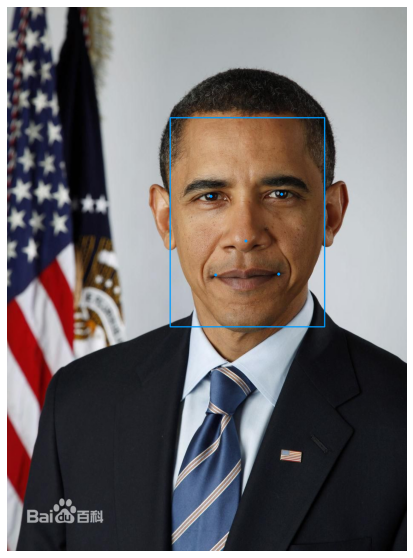

In [9]:
import matplotlib.pyplot as plt

img_with_dets = img.copy()
min_conf = 0.9
for det in detections:
    if det['confidence'] >= min_conf:
        x, y, width, height = det['box']
        keypoints = det['keypoints']
        print(f"BBox {det['box']}")
        cv2.rectangle(img_with_dets, (x,y), (x+width,y+height), (0,155,255), 2)
        cv2.circle(img_with_dets, (keypoints['left_eye']), 2, (0,155,255), 2)
        cv2.circle(img_with_dets, (keypoints['right_eye']), 2, (0,155,255), 2)
        cv2.circle(img_with_dets, (keypoints['nose']), 2, (0,155,255), 2)
        cv2.circle(img_with_dets, (keypoints['mouth_left']), 2, (0,155,255), 2)
        cv2.circle(img_with_dets, (keypoints['mouth_right']), 2, (0,155,255), 2)
plt.figure(figsize = (10,10))
plt.imshow(img_with_dets)
plt.axis('off')